In [3]:
from google.colab import files
uploaded = files.upload()

Saving DatasetBrainTumor.rar to DatasetBrainTumor.rar


In [4]:
!unrar x "/content/DatasetBrainTumor.rar"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/DatasetBrainTumor.rar

Creating    DatasetBrainTumor                                         OK
Creating    DatasetBrainTumor/meningioma                              OK
Extracting  DatasetBrainTumor/meningioma/1.jpg                             0%  OK 
Extracting  DatasetBrainTumor/meningioma/10.jpg                            0%  OK 
Extracting  DatasetBrainTumor/meningioma/100.jpg                           0%  OK 
Creating    DatasetBrainTumor/pituitary tumor                         OK
Extracting  DatasetBrainTumor/pituitary tumor/1000.jpg                     1%  OK 
Extracting  DatasetBrainTumor/pituitary tumor/1001.jpg                     1%  OK 
Extracting  DatasetBrainTumor/pituitary tumor/1002.jpg                     2%  OK 
Extracting  DatasetBrainTumor/pituitary tumor/1003.jpg                     2%  OK 
Extracting  D

In [5]:
import pandas as pd
import os
import tensorflow as tf
import keras.preprocessing
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import glob
from tqdm import tqdm
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import *

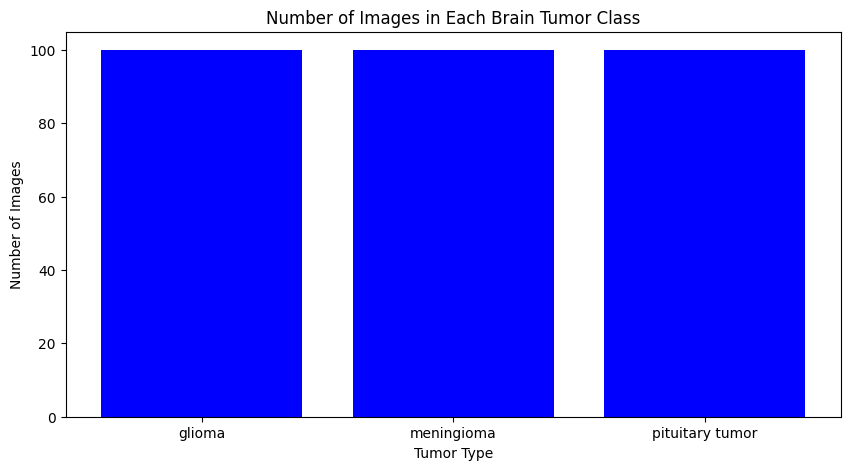

In [6]:
parent_dir = 'DatasetBrainTumor'
class_names = ['glioma', 'meningioma', 'pituitary tumor']

image_counts = {}

for class_name in class_names:
  class_dir = os.path.join(parent_dir, class_name)
  image_counts[class_name] = len(os.listdir(class_dir))

classes = list(image_counts.keys())
counts = list(image_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color=['blue'])
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Brain Tumor Class')
plt.show()

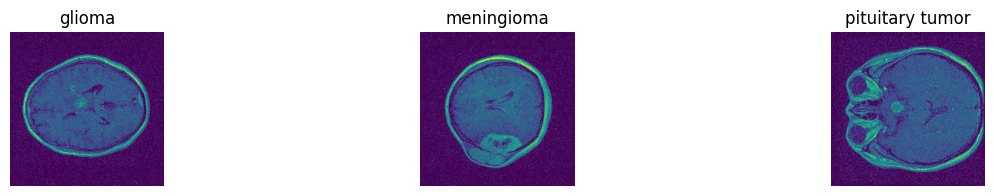

In [7]:
# Augmentasi untuk optimasi SGD
# Create an augmenter sequence
augmenter = iaa.Sequential([
    iaa.Resize({"height": 200, "width": 200}),  # Resize images
    #iaa.Fliplr(0.5),  # Horizontal flip 50% of the images
    #iaa.Rotate((-15, 15)),  # Rotate images between -20 and 20 degrees
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
    #iaa.Multiply((1/255.0)), # Change brightness
])

# Function to load, augment, and save images
def augment_and_save_images(class_name, output_dir):
    class_dir = os.path.join(parent_dir, class_name)
    augmented_dir = os.path.join(output_dir, class_name)
    os.makedirs(augmented_dir, exist_ok=True)

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image = Image.open(img_path)
        image_np = np.array(image)

        # Augment the image
        augmented_image_np = augmenter(image=image_np)
        augmented_image = Image.fromarray(augmented_image_np)

        # Save the augmented image
        augmented_image.save(os.path.join(augmented_dir, img_name))

# Apply augmentation to all classes
output_dir = 'augmented_datasetbraintumor'
for class_name in class_names:
    augment_and_save_images(class_name, output_dir)

# Display some augmented images
augmented_images = []
for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    img_path = os.path.join(class_dir, os.listdir(class_dir)[0])
    image = Image.open(img_path)
    augmented_images.append(image)

plt.figure(figsize=(15, 2))
for i, img in enumerate(augmented_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

In [8]:
!pip install tensorflow

In [9]:
# Function to load images and labels
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(128, 128))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(class_name)
    return np.array(images), np.array(labels)

In [10]:
# Load images and labels
images, labels = load_images_from_directory('augmented_datasetbraintumor')

# Encode labels as integers
label_to_index = {label: index for index, label in enumerate(np.unique(labels))}
encoded_labels = np.array([label_to_index[label] for label in labels])

In [11]:
# Split the data into train (80%), validation (10%), and test (10%) sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, encoded_labels, test_size=0.10, stratify=encoded_labels)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.10, stratify=temp_labels)

In [12]:
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Create data generators
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

In [14]:
# Function to build the model

def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        #Conv2D(128, (3, 3), activation='relu'),
        #MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(rate= 0.5),
        Dense(len(np.unique(labels)), activation='softmax')  # Number of classes
    ])
    return model

In [15]:
# Define optimizers
optimizers = {
    'SGD': SGD(learning_rate=0.001, momentum=0.9),
}

history = {}
results = {}

In [16]:
for opt_name, optimizer in optimizers.items():
    print(f'Training with {opt_name} optimizer...')
    model = build_model()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,mode='auto', restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,verbose=1, mode='auto')
    hist = model.fit(
        train_generator,
        epochs=50,
        shuffle = False,
        validation_data=val_generator,
        callbacks=[reduce_lr,early_stop]
    )

Training with SGD optimizer...
Epoch 1/50
9/9 [==============================] - 9s 139ms/step - loss: 1.0922 - accuracy: 0.4037 - val_loss: 1.0586 - val_accuracy: 0.7037 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 0s 25ms/step - loss: 1.0492 - accuracy: 0.5074 - val_loss: 1.0063 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 0s 25ms/step - loss: 0.9760 - accuracy: 0.6593 - val_loss: 0.9363 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 0s 24ms/step - loss: 0.9105 - accuracy: 0.6963 - val_loss: 0.8604 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 0s 24ms/step - loss: 0.8199 - accuracy: 0.6852 - val_loss: 0.7734 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 0s 23ms/step - loss: 0.7300 - accuracy: 0.7481 - val_loss: 0.6917 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 0s 28m

In [17]:
# Save training history
history[opt_name] = hist

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

# Save the results
results[opt_name] = {
    'train_acc': hist.history['accuracy'][-1] * 100,
    'val_acc': hist.history['val_accuracy'][-1] * 100,
    'train_loss': hist.history['loss'][-1] * 100,
    'val_loss': hist.history['val_loss'][-1] * 100,
}

1/1 [==============================] - 1s 633ms/step - loss: 0.0154 - accuracy: 1.0000


In [18]:
# Function to plot training history
def plot_training_history(history):
    for opt_name, hist in history.items():
        # Convert accuracy to percentage
        train_acc = [x * 100 for x in hist.history['accuracy']]
        val_acc = [x * 100 for x in hist.history['val_accuracy']]
        train_loss = [x * 100 for x in hist.history['accuracy']]
        val_loss = [x * 100 for x in hist.history['val_accuracy']]

        plt.figure(figsize=(14, 5))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(train_acc, label='Train Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.title(f'{opt_name} Optimizer - Model Accuracy')
        plt.ylabel('Accuracy (%)')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Validation Loss')
        plt.title(f'{opt_name} Optimizer - Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

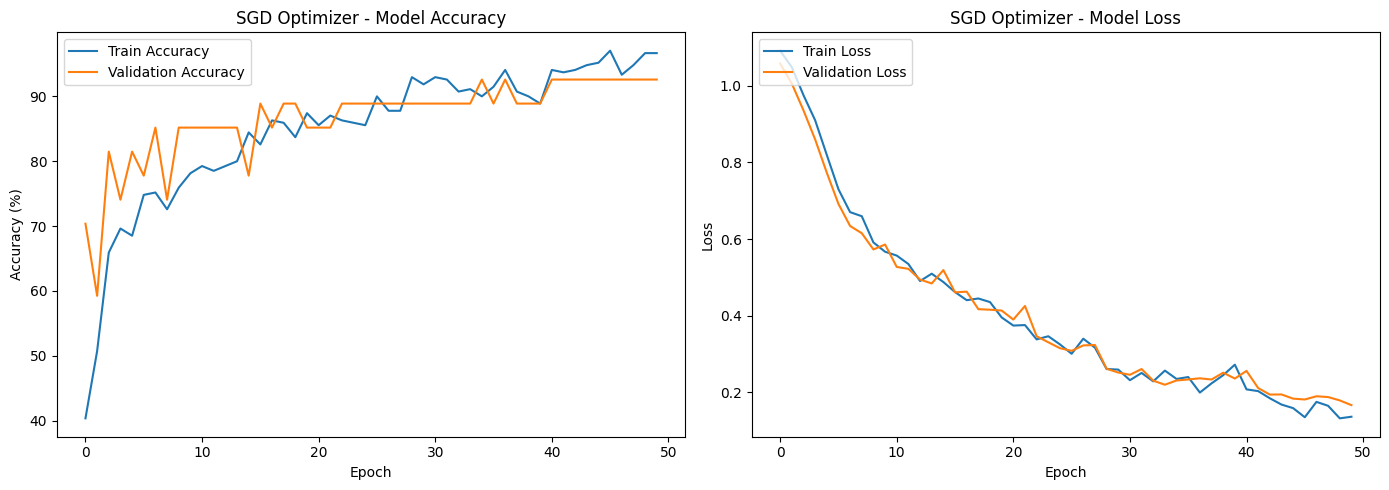

In [19]:
# Plot the training history
plot_training_history(history)

In [21]:
# Print the results
for opt_name, result in results.items():
    print(f"Results for {opt_name} Optimizer:")
    print(f"Train Accuracy: {result['train_acc']:.2f}%")
    print(f"Validation Accuracy: {result['val_acc']:.2f}%")
    print(f"Train Loss: {result['train_loss']:.2f}%")
    print(f"Validation Loss: {result['val_loss']:.2f}%")

Results for SGD Optimizer:
Train Accuracy: 96.67%
Validation Accuracy: 92.59%
Train Loss: 13.54%
Validation Loss: 16.57%
